In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc

In [3]:
sampled_adata = sc.read_h5ad("/gpfs/gibbs/pi/zhao/tl688/cpsc_finalproject/genept_data/sample_aorta_data_updated.h5ad")

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust_gcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
mapping_dict_phenotype = {
 'affected_1': 'Ascending only',
 'affected_2': 'Ascending only',
 'affected_3': 'Ascending w/ root',
 'affected_4': 'Ascending only',
 'affected_5': 'Ascending w/ root',
 'affected_6': 'Ascending to descending',
 'affected_7': 'Ascending w/ root',
 'affected_8': 'Ascending w/ root',
 'control_1':'Control',
 'control_2':'Control',
 'control_3':'Control'
}
sampled_adata.obs['phenotype'] = sampled_adata.obs.patient.map(mapping_dict_phenotype)

In [5]:
sampled_adata.uns['log1p']['base'] = None
sc.pp.highly_variable_genes(sampled_adata, n_top_genes=2000)
sampled_adata = sampled_adata[:,sampled_adata.var.highly_variable]

In [6]:
sampled_adata

View of AnnData object with n_obs × n_vars = 9625 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata = sampled_adata

In [9]:
adata

View of AnnData object with n_obs × n_vars = 9625 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust_gcn/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust_gcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust_gcn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


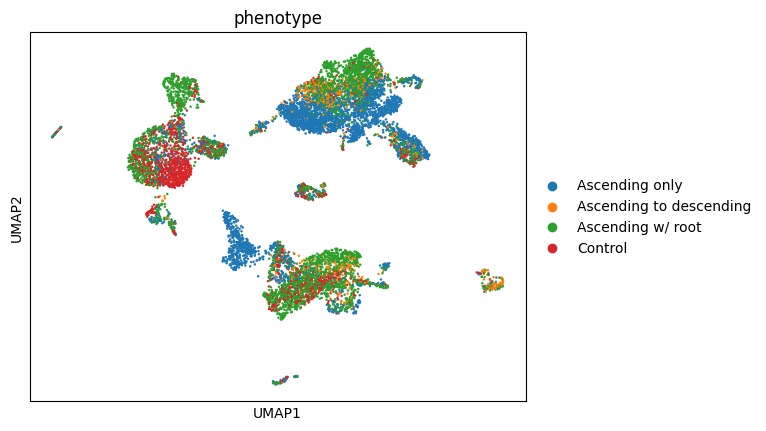

In [11]:
sc.pl.umap(adata, color='phenotype')

In [9]:
import torch
import torch.nn.functional as F
import lightning as L
import os
import pandas as pd
import numpy as np
import pickle
import sklearn.model_selection
import scipy.stats
import sklearn.metrics
import scanpy as sc

from torch.utils.data import DataLoader
from torch import nn
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


In [10]:
layers =[2000, 512, len(set(adata.obs['celltype']))]

In [11]:
# layers

In [12]:
# train_obs

In [9]:
sampled_adata = sampled_adata[np.where(sampled_adata.obs.celltype!='Unknown')[0]]

In [10]:
sampled_adata

View of AnnData object with n_obs × n_vars = 9612 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
label_data = le.fit_transform(sampled_adata.obs['celltype'])

In [17]:
sampled_adata.obs["phenotype"]

index
CCCAACTAGTCACTAC.1ATAA5          Ascending w/ root
TCGGGCACACGCAAAG.1ATAA6    Ascending to descending
TCGAGGCGTCATACTG.1ATAA1             Ascending only
TTGACTTGTGCGCTTG.1ATAA2             Ascending only
CGAGTGCAGTAAGACT.1ATAA7          Ascending w/ root
                                    ...           
GTTAGACCACCAAATC.1ATAA5          Ascending w/ root
CGAGGAAAGATAGCTA.1ATAA8          Ascending w/ root
TAAGTCGAGTCACACT.1ATAA6    Ascending to descending
GAACACTGTCGTTCAA.1ATAA6    Ascending to descending
GTCACGGAGAAACACT.1ATAA8          Ascending w/ root
Name: phenotype, Length: 9612, dtype: object

In [18]:
# import sklearn.model_selection 
# train_obs,test_obs,train_label,test_label = sklearn.model_selection.train_test_split(sampled_adata.obs_names, 
#                                                     sampled_adata.obs.phenotype,
#                                                     test_size=0.20, random_state=2023)

In [19]:
# adata_train = sampled_adata[train_obs]
# adata_test = sampled_adata[test_obs]

In [11]:
adata_train = sampled_adata[sampled_adata.obs["phenotype"] == 'Control']

In [21]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):

    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [22]:
class Encoder(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.shared_layers = nn.Sequential(nn.Linear(layers[0], layers[1]), 
                                nn.BatchNorm1d(layers[1]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[1], layers[1]),
                                nn.BatchNorm1d(layers[1]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[1], layers[2])
                               )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        return self.softmax (self.shared_layers(x))
        



class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.loss = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        
        output_label = self.encoder(x)
        
        loss = self.loss(output_label, y.long())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        
        output_label = self.encoder(x)
        
        val_loss = self.loss(output_label, y.long())
        
        self.log("val_loss", val_loss.item())
        return val_loss

        
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        
        output_label = self.encoder(x)
        
        test_loss = self.loss(output_label, y.long())
        self.log("test_loss", test_loss.item())
        return test_loss
        
    def forward(self, x):
        return self.encoder(x)

    def configure_optimizers(self):
            optimizer = torch.optim.Adam(
                params=self.parameters(), 
                lr=eta
)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=10,
                verbose=True
            )
            return {
               'optimizer': optimizer,
               'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
               'monitor': 'val_loss'
           }


In [23]:
label_data = le.transform(adata_train.obs['celltype'])

In [24]:
adata_train.X

ArrayView([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.4147421, 0.7070306, ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           ...,
           [0.5620156, 0.       , 0.       , ..., 0.5620156, 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ]], dtype=float32)

In [25]:
import sklearn.model_selection 

In [26]:
X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(adata_train.X.toarray(), label_data, random_state=2023)

In [27]:
X_test = X_tr
y_test = y_tr

In [36]:
X_tr, X_val, X_train, X_test, y_tr, y_val, y_train, y_test =torch.FloatTensor(X_tr),torch.FloatTensor(X_val),torch.FloatTensor(X_tr),torch.FloatTensor(X_test),torch.FloatTensor(y_tr), torch.FloatTensor(y_val), torch.FloatTensor(y_tr), torch.FloatTensor(y_test)


train_dataset = torch.utils.data.TensorDataset(X_tr, y_tr)
valid_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_tr, y_tr)

epochs = 1000 
act_func = 'GELU'
dropout = 0.5 
input_dropout = 0.2
eta = 1e-4
norm = 'tanh' 
drug_num_dim = 16

model = LitAutoEncoder(Encoder())

print(model.log) #see log and log dir for model place

lr_monitor = LearningRateMonitor(logging_interval='step')

train_loader = DataLoader(train_dataset, batch_size=4096, num_workers=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, num_workers=5)

# train with both splits
trainer = L.Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=100)], max_epochs=1000)

trainer.log_dir

# trainer.fit(model, train_loader, valid_loader)

# trainer.test(model, dataloaders=DataLoader(test_dataset, batch_size=1024, num_workers=5))

checkpoint = torch.load("/gpfs/gibbs/pi/zhao/tl688/adversial_training/lightning_logs/version_24521077/checkpoints/epoch=299-step=300.ckpt")
model.load_state_dict(checkpoint["state_dict"])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<bound method LightningModule.log of LitAutoEncoder(
  (encoder): Encoder(
    (shared_layers): Sequential(
      (0): Linear(in_features=2000, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=512, out_features=12, bias=True)
    )
    (softmax): Softmax(dim=1)
  )
  (loss): CrossEntropyLoss()
)>


<All keys matched successfully>

In [37]:
print(trainer.log_dir)

/gpfs/gibbs/pi/zhao/tl688/adversial_training/lightning_logs/version_24583286


In [38]:
for m in model.encoder.modules():

    for child in m.children():

        if type(child) == nn.BatchNorm1d:

            child.track_running_stats = False

            child.running_mean = None

            child.running_var = None
model.encoder.eval()

Encoder(
  (shared_layers): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=12, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [39]:
with torch.no_grad():
    y_pred = model.encoder(X_tr)
    _ , y_pred = torch.max(y_pred, 1)

In [40]:
train_label = le.inverse_transform(y_pred.cpu())

In [41]:
y_pred

tensor([ 5,  5, 10,  ...,  2,  5,  3])

In [42]:
y_tr

tensor([ 5.,  5., 10.,  ...,  2.,  5.,  3.])

In [43]:
sklearn.metrics.classification_report(y_tr, y_pred.cpu())

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00        10\n         1.0       1.00      1.00      1.00        52\n         2.0       0.99      1.00      1.00       200\n         3.0       0.98      0.93      0.96        58\n         4.0       1.00      1.00      1.00        10\n         5.0       1.00      1.00      1.00       304\n         6.0       1.00      1.00      1.00        44\n         7.0       1.00      1.00      1.00         6\n         8.0       0.99      0.99      0.99       409\n         9.0       1.00      1.00      1.00        79\n        10.0       1.00      1.00      1.00        77\n\n    accuracy                           0.99      1249\n   macro avg       1.00      0.99      0.99      1249\nweighted avg       0.99      0.99      0.99      1249\n'

In [46]:
model.encoder

Encoder(
  (shared_layers): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=12, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [47]:
sample_test = adata[adata.obs['phenotype'] == 'Ascending w/ root']

In [48]:
sample_test

View of AnnData object with n_obs × n_vars = 3680 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [49]:
X_test = torch.FloatTensor(sample_test.X)

In [51]:
with torch.no_grad():
    y_pred = model.encoder(X_test)
    _ , y_pred = torch.max(y_pred, 1)

In [52]:
y_pred

tensor([5, 8, 9,  ..., 5, 6, 5])

In [53]:
label_test = le.inverse_transform(y_pred.cpu())

In [54]:
sklearn.metrics.classification_report(sample_test.obs['celltype'].values, label_test)

'              precision    recall  f1-score   support\n\n       Bcell       0.92      0.88      0.90        26\n          EC       0.94      0.99      0.96        75\n  Fibroblast       0.89      0.91      0.90       401\n         MSC       0.97      0.80      0.88        86\n    Mastcell       1.00      1.00      1.00        13\n  MonoMaphDC       1.00      0.98      0.99      1291\n          NK       0.71      0.95      0.82       123\n      Plasma       0.97      0.90      0.93        39\n        SMC1       0.73      0.89      0.80       336\n        SMC2       0.81      0.87      0.84       139\n       Tcell       1.00      0.91      0.95      1151\n\n    accuracy                           0.93      3680\n   macro avg       0.90      0.92      0.91      3680\nweighted avg       0.94      0.93      0.94      3680\n'

In [55]:
adata.obs['phenotype']

index
CCCAACTAGTCACTAC.1ATAA5          Ascending w/ root
TCGGGCACACGCAAAG.1ATAA6    Ascending to descending
TCGAGGCGTCATACTG.1ATAA1             Ascending only
TTGACTTGTGCGCTTG.1ATAA2             Ascending only
CGAGTGCAGTAAGACT.1ATAA7          Ascending w/ root
                                    ...           
GTTAGACCACCAAATC.1ATAA5          Ascending w/ root
CGAGGAAAGATAGCTA.1ATAA8          Ascending w/ root
TAAGTCGAGTCACACT.1ATAA6    Ascending to descending
GAACACTGTCGTTCAA.1ATAA6    Ascending to descending
GTCACGGAGAAACACT.1ATAA8          Ascending w/ root
Name: phenotype, Length: 9625, dtype: category
Categories (4, object): ['Ascending only', 'Ascending to descending', 'Ascending w/ root', 'Control']

In [15]:
sample_test = adata[adata.obs['phenotype'] == 'Ascending to descending']

In [18]:
sample_test.obs['celltype'].value_counts()

celltype
Tcell         351
MonoMaphDC    210
Plasma         78
NK             37
Fibroblast     15
SMC1            6
Bcell           3
MSC             3
Mastcell        3
SMC2            3
EC              2
Name: count, dtype: int64

In [19]:
adata_train.obs['celltype'].value_counts()

celltype
SMC1          543
MonoMaphDC    402
Fibroblast    281
Tcell         111
SMC2          101
MSC            71
NK             63
EC             61
Mastcell       14
Bcell          12
Plasma          7
Name: count, dtype: int64

In [58]:
X_test = torch.FloatTensor(sample_test.X)

In [59]:
with torch.no_grad():
    y_pred = model.encoder(X_test)
    _ , y_pred = torch.max(y_pred, 1)

In [60]:
y_pred

tensor([10,  8,  8, 10, 10,  5,  5, 10,  7,  8, 10,  2, 10,  0,  7,  5,  6,  5,
         5, 10,  7,  8,  5,  3,  7,  8,  2,  5,  8,  7,  5,  5,  8,  7,  5,  5,
         5,  8,  7, 10,  8,  8,  5,  8,  8,  5,  5,  8,  6,  7,  8,  9,  2,  2,
        10,  5,  5,  5,  5,  8, 10,  5,  2,  2,  2,  5,  8, 10,  5,  8,  8,  5,
         5,  5,  5, 10,  8,  8,  5, 10, 10,  8,  8,  2,  5, 10, 10, 10,  5, 10,
         7,  5,  8,  8, 10,  2,  5,  8,  5,  2,  8,  8,  5,  5,  5,  7,  5,  7,
         6,  8,  8,  8,  9,  5,  2,  8,  5,  7,  8,  5,  5,  8,  8,  5,  5,  5,
         7,  2, 10,  5,  8,  7,  5, 10,  5, 10,  5,  5,  6,  5,  5,  2,  7, 10,
        10,  8,  2,  5,  8,  5,  5,  5,  5, 10,  2,  6,  8,  8,  5,  8, 10,  8,
         5,  5, 10,  5,  7,  7,  8,  5,  5,  8,  2, 10,  9,  8,  7,  0,  8,  8,
        10,  2,  8,  8,  7,  6,  8,  9, 10,  7,  8,  7,  8,  7,  2,  7,  6,  8,
         7,  7,  8, 10,  5, 10,  8,  5,  8, 10, 10,  8, 10,  5,  5, 10,  8,  2,
         5,  5, 10,  5,  9,  2,  5,  2, 

In [61]:
label_test = le.inverse_transform(y_pred.cpu())

In [62]:
sklearn.metrics.classification_report(sample_test.obs['celltype'].values, label_test)

'              precision    recall  f1-score   support\n\n       Bcell       1.00      0.67      0.80         3\n          EC       1.00      0.50      0.67         2\n  Fibroblast       0.29      1.00      0.45        15\n         MSC       1.00      1.00      1.00         3\n    Mastcell       1.00      1.00      1.00         3\n  MonoMaphDC       1.00      0.99      0.99       210\n          NK       0.91      0.86      0.89        37\n      Plasma       1.00      0.74      0.85        78\n        SMC1       0.02      0.67      0.04         6\n        SMC2       0.27      1.00      0.43         3\n       Tcell       1.00      0.36      0.53       351\n\n    accuracy                           0.64       711\n   macro avg       0.77      0.80      0.69       711\nweighted avg       0.97      0.64      0.72       711\n'

In [12]:
sample_test = adata[adata.obs['phenotype'] == 'Ascending only']

In [13]:
sample_test

View of AnnData object with n_obs × n_vars = 3568 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [14]:
adata_train

View of AnnData object with n_obs × n_vars = 1666 × 2000
    obs: 'patient', 'status', 'n_counts', 'n_counts_normalized', 'n_counts_normalized_log', 'cell_id', 'patient_rename', 'Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2', 'cellcycle', 'split_value', 'phenotype'
    var: 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'patient_colors', 'pca', 'status_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [46]:
X_test = torch.FloatTensor(sample_test.X)

In [47]:
with torch.no_grad():
    y_pred = model.encoder(X_test)
    _ , y_pred = torch.max(y_pred, 1)

In [48]:
y_pred

tensor([10,  2,  5,  ...,  2,  8,  5])

In [49]:
label_test = le.inverse_transform(y_pred.cpu())

In [50]:
sklearn.metrics.classification_report(sample_test.obs['celltype'].values, label_test)

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n       Bcell       0.96      1.00      0.98        22\n          EC       0.97      1.00      0.98        28\n  Fibroblast       0.19      0.88      0.31        73\n         MSC       0.79      0.94      0.86        33\n    Mastcell       1.00      1.00      1.00        15\n  MonoMaphDC       0.98      0.97      0.97       787\n          NK       0.75      0.91      0.82       292\n      Plasma       0.94      1.00      0.97        17\n        SMC1       0.04      0.82      0.08        62\n        SMC2       0.45      0.86      0.59        51\n       Tcell       1.00      0.32      0.48      2175\n     Unknown       0.00      0.00      0.00        13\n\n    accuracy                           0.56      3568\n   macro avg       0.67      0.81      0.67      3568\nweighted avg       0.93      0.56      0.62      3568\n'